<a href="https://colab.research.google.com/github/vmmadathil/paper_recreations/blob/master/alex_net/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time
import datetime

In [3]:
##loading in the CIFAR10 dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [4]:
## creating the validation sets as well by taking the last 5000 images
validation_images, validation_labels = train_images[:5000], train_labels[:5000]
train_images, train_labels = train_images[5000:], train_labels[5000:]

In [5]:
print(type(train_images), type(train_labels))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [6]:
print(len(train_images))
print(len(test_images))
print(len(validation_images))

45000
10000
5000


In [7]:
import random
random.seed(30)

train_index = random.sample(range(45000), 11250)
test_index = random.sample(range(10000), 2500)
val_index = random.sample(range(5000), 1250)

In [8]:
#randomly selecting half of the dataset for RAM limitations
train_images = train_images[train_index]
train_labels = train_labels[train_index]

test_images = train_images[test_index]
test_labels = train_labels[test_index]

validation_images = validation_images[val_index]
validation_labels = validation_labels[val_index]

In [9]:
## creating a tensorflow dataset representation
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

In [10]:
#class names
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

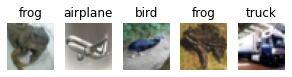

In [11]:
#visualizing some of the training set
plt.figure(figsize = (5, 5))

for i, (image, label) in enumerate(train_ds.take(5)):
  ax = plt.subplot(5,5,i+1)
  plt.imshow(image)
  plt.title(CLASS_NAMES[label.numpy()[0]])
  plt.axis('off')

In [12]:
#looking at the size of the datasets
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", validation_ds_size)

Training data size: 11250
Test data size: 2500
Validation data size: 1250


In [13]:
#function to process images 
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 277x277
    image = tf.image.resize(image, (227,227))
    return image, label

In [14]:
batch_size = 32

train_ds = train_ds.map(process_images).shuffle(buffer_size=train_ds_size).batch(batch_size = batch_size, drop_remainder = True)

test_ds = test_ds.map(process_images).shuffle(buffer_size=test_ds_size).batch(batch_size = batch_size, drop_remainder = True)

validation_ds = validation_ds.map(process_images).shuffle(buffer_size=validation_ds_size).batch(batch_size = batch_size, drop_remainder = True)

In [15]:
#implementing the model
model = keras.models.Sequential([
  #1st conv layer -- 96 kernels, size 11 x 11 x 3, stride of 4
  keras.layers.Conv2D(filters = 96,
                       kernel_size = (11, 11),
                       strides = (4, 4),
                       input_shape = (227, 227, 3),
                       activation = 'relu'),
  #response normalization
  keras.layers.BatchNormalization(),
  #max-pooling
  keras.layers.MaxPool2D(pool_size = (3, 3), 
                         strides = (2, 2)),
  #2nd conv layer -- 256 kernels, size 5 x 5 x 48
  keras.layers.Conv2D(filters = 256,
                       kernel_size = (5, 5),
                       strides = (1, 1),
                       padding = "same",
                       activation = 'relu'),
  #response normalization
  keras.layers.BatchNormalization(),
  #max-pooling
  keras.layers.MaxPool2D(pool_size = (3, 3),
                          strides = (2, 2)),
  #3rd conv layer -- 384 kernels, size 3 x 3 x 256
  keras.layers.Conv2D(filters = 384,
                      kernel_size = (3, 3),
                      strides = (1, 1),
                      padding = 'same',
                      activation = 'relu'),
  #4th conv layer -- 384 kernels, size 3 x 3 x 192
  keras.layers.Conv2D(filters = 384,
                      kernel_size = (3, 3),
                      strides = (1, 1),
                      padding = 'same',
                      activation = 'relu'),
  #5th conv layer -- 256 kernels, size 3 x 3 x 192
  keras.layers.Conv2D(filters = 256,
                      kernel_size = (3, 3),
                      strides  = (1, 1),
                      padding = 'same',
                      activation = 'relu'),
  #max-pooling
  keras.layers.MaxPool2D(pool_size = (3, 3),
                         strides = (2,2)),
  #flattening layer
  keras.layers.Flatten(),
  #fully conected layer -- 4096 neurons
  keras.layers.Dense(4096, activation = 'relu'),
  #fully conected layer -- 4096 neurons
  keras.layers.Dense(4096, activation = 'relu'),
  #last layer -- 10 neurons
  keras.layers.Dense(10, activation = 'softmax')
])

In [16]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.01), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       8

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [17]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [18]:
log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

In [19]:
# callbacks at training
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if (logs.get("accuracy")==1.00 and logs.get("loss")<0.03):
            print("\nReached 100% accuracy so stopping training")
            self.model.stop_training =True
callbacks = myCallback()

In [20]:
model.fit(train_ds,
          epochs=50,
          validation_data = validation_ds,
          validation_freq=1,
          callbacks=[tensorboard_callback, callbacks])

Epoch 1/50
351/351 [==============================] - 54s 49ms/step - loss: 1.7108 - accuracy: 0.3854 - val_loss: 1.4916 - val_accuracy: 0.4912
Epoch 2/50
351/351 [==============================] - 19s 46ms/step - loss: 1.3184 - accuracy: 0.5265 - val_loss: 1.2916 - val_accuracy: 0.5521
Epoch 3/50
351/351 [==============================] - 19s 46ms/step - loss: 1.0947 - accuracy: 0.6115 - val_loss: 1.2868 - val_accuracy: 0.5489
Epoch 4/50
351/351 [==============================] - 20s 47ms/step - loss: 0.9046 - accuracy: 0.6814 - val_loss: 1.2943 - val_accuracy: 0.5497
Epoch 5/50
351/351 [==============================] - 19s 47ms/step - loss: 0.7322 - accuracy: 0.7424 - val_loss: 1.0864 - val_accuracy: 0.6234
Epoch 6/50
351/351 [==============================] - 19s 47ms/step - loss: 0.5379 - accuracy: 0.8156 - val_loss: 1.1398 - val_accuracy: 0.6266
Epoch 7/50
351/351 [==============================] - 20s 48ms/step - loss: 0.3677 - accuracy: 0.8746 - val_loss: 1.2057 - val_accuracy:

In [21]:
# Saving the model
model.save('AlexNet_saved_model/')

INFO:tensorflow:Assets written to: AlexNet_saved_model/assets


In [23]:
## Evaluating the model
loss, acc = model.evaluate(test_ds)
print("accuracy:{:.2f}%".format(acc*100))

78/78 [==============================] - 3s 23ms/step - loss: 6.3605e-04 - accuracy: 1.0000
accuracy:100.00%
